# Phase 2: Feature Engineering

In this notebook we will:
1. Load interim datasets.  
2. Encode categorical variables.  
3. Extract date-based features.  
4. Scale numeric features (Standard & MinMax).  
5. Visualize before/after scaling.  
6. Feature Extraction: PCA & L1/L2.  
7. Save processed datasets.

In [ ]:
# Parameters cell for Papermill
RAW       = "/data/raw"
INTERIM   = "/data/interim"
PROCESSED = "/data/processed"

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

DATA_INT = os.path.join("..", "data", "interim")
historical = pd.read_csv(f"{DATA_INT}/historical_clean.csv", parse_dates=['date'])
coins      = pd.read_csv(f"{DATA_INT}/coins_clean.csv")

## 1. One-Hot Encode Categorical Variables

In [2]:
coins_ohe = pd.get_dummies(coins, columns=['status','category'], drop_first=True)
display(coins_ohe.filter(like='status_').head())
display(coins_ohe.filter(like='category_').head())

,status_extinct,status_inactive,status_untracked
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


,category_token
0,False
1,False
2,False
3,False
4,False


## 2. Extract Date Features

In [3]:
historical['year']    = historical['date'].dt.year
historical['month']   = historical['date'].dt.month
historical['day']     = historical['date'].dt.day
historical['weekday'] = historical['date'].dt.weekday
display(historical[['date','year','month','day','weekday']].head())

,date,year,month,day,weekday
0,2013-04-28,2013,4,28,6
1,2013-04-28,2013,4,28,6
2,2013-04-28,2013,4,28,6
3,2013-04-28,2013,4,28,6
4,2013-04-28,2013,4,28,6


## 3. Scale Numeric Features

In [4]:
num_cols = ['price','market_cap','volume_24h','percent_change_24h']
scaler_std = StandardScaler()
scaler_mm  = MinMaxScaler()

std_vals = scaler_std.fit_transform(historical[num_cols])
mm_vals  = scaler_mm.fit_transform(historical[num_cols])

hist_std = pd.DataFrame(std_vals, columns=[f"{c}_std" for c in num_cols])
hist_mm  = pd.DataFrame(mm_vals,  columns=[f"{c}_mm"  for c in num_cols])

historical = pd.concat([historical, hist_std, hist_mm], axis=1)

## 4. Before vs. After Scaling

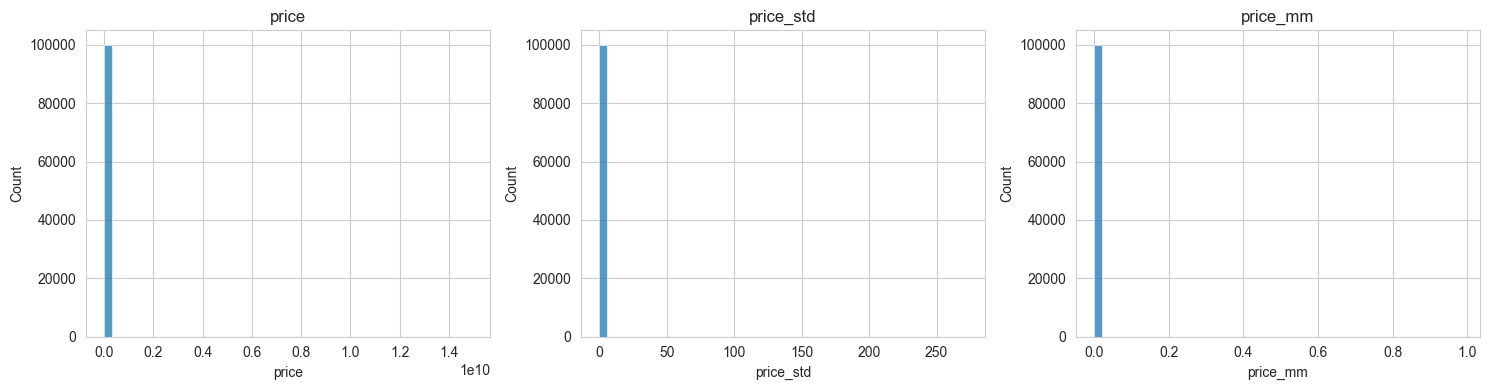

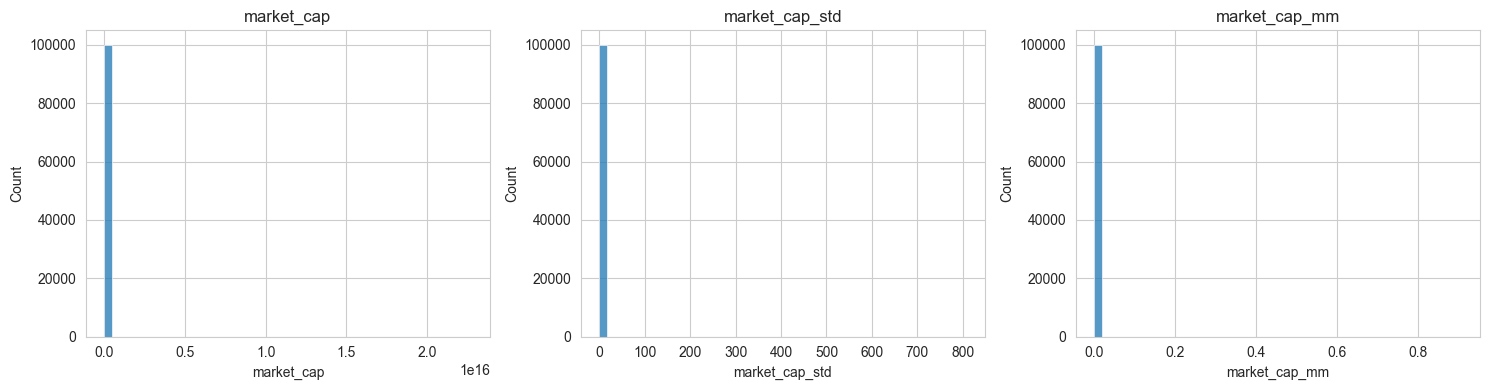

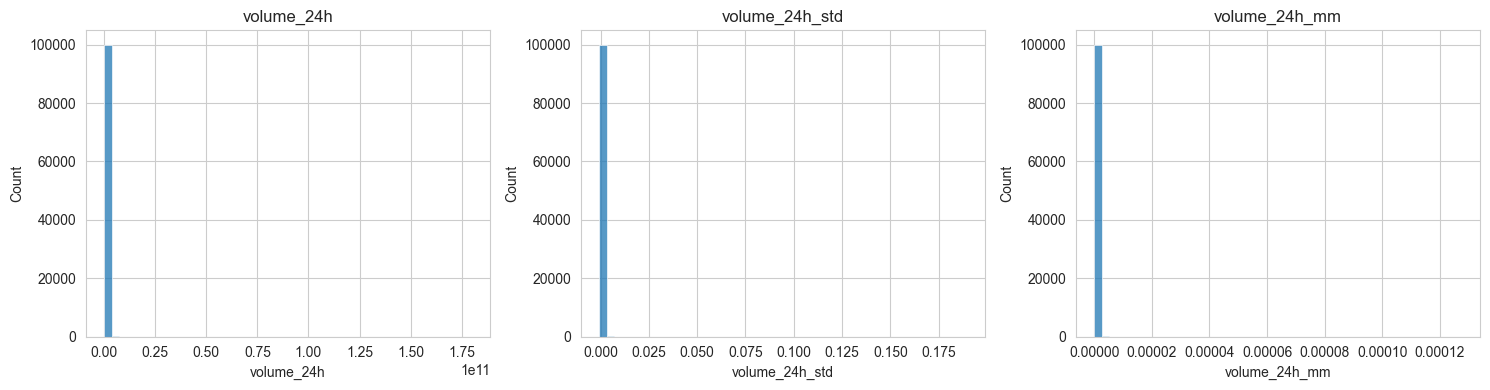

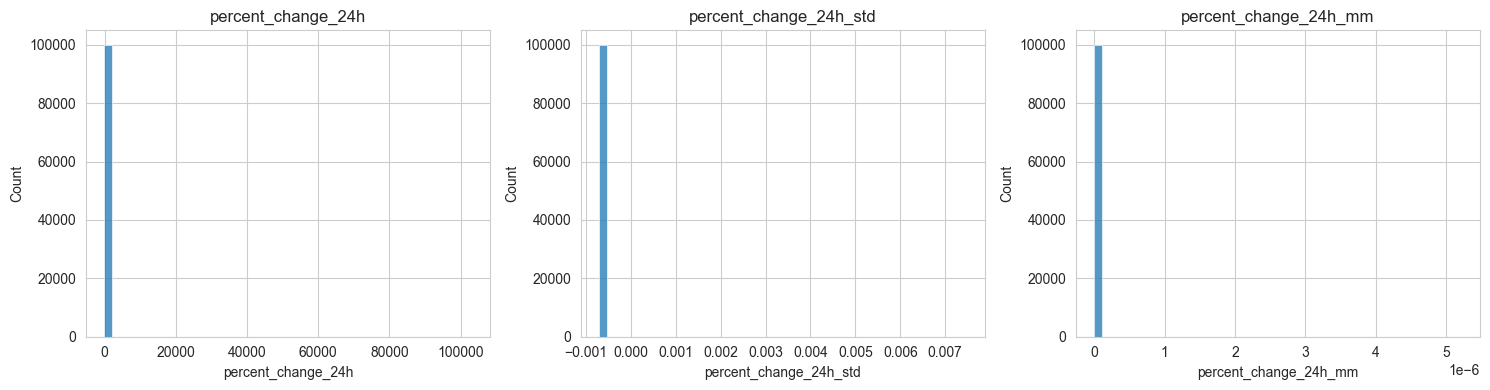

In [5]:
# Subsampling & fixed bins to avoid MemoryError
def subsample(series, n=100_000):
    return series.sample(n, random_state=42) if len(series)>n else series

for orig in num_cols:
    std = f"{orig}_std"; mm = f"{orig}_mm"
    data_orig = subsample(historical[orig].dropna())
    data_std  = subsample(historical[std].dropna())
    data_mm   = subsample(historical[mm].dropna())
    fig, ax = plt.subplots(1,3,figsize=(15,4))
    sns.histplot(data_orig, bins=50, ax=ax[0]).set_title(orig)
    sns.histplot(data_std,  bins=50, ax=ax[1]).set_title(std)
    sns.histplot(data_mm,   bins=50, ax=ax[2]).set_title(mm)
    plt.tight_layout(); plt.show()

## 5. Feature Extraction: PCA

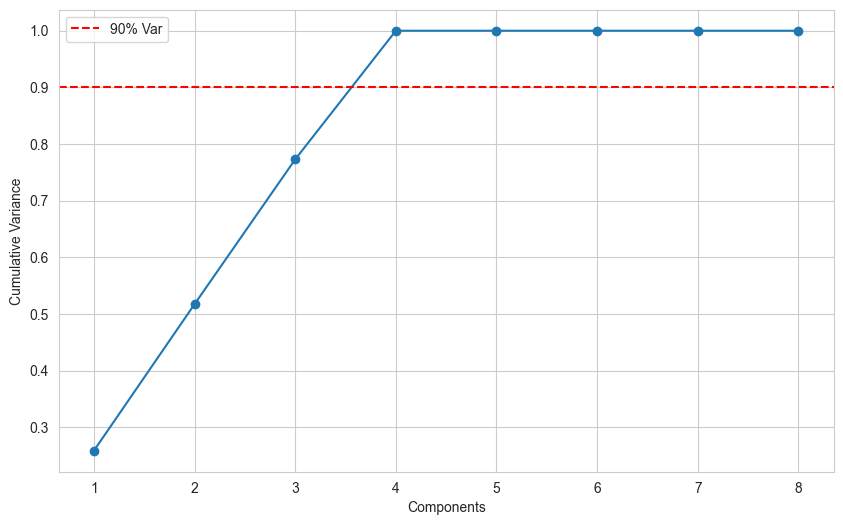

Components for 90% variance: 4


In [6]:
# 1) Identify scaled cols & impute NaNs
scaled_cols = [c for c in historical.columns if c.endswith(("_std","_mm"))]
imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(historical[scaled_cols])

# 2) Fit PCA & plot explained variance
pca = PCA(); pca.fit(X_scaled)
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1,len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% Var')
plt.xlabel("Components"); plt.ylabel("Cumulative Variance"); plt.legend()
plt.show()

n_components_90 = np.searchsorted(cum_var,0.90)+1
print(f"Components for 90% variance: {n_components_90}")

## 6. Feature Selection via L1/L2 Regularization

We’ll use **Lasso** (L1) and **Ridge** (L2) regression on `price` to rank features:
1. Fit each model using our scaled (imputed) features.  
2. Examine coefficient magnitudes:  
   - **Lasso** zeros out less important features.  
   - **Ridge** shrinks less important ones towards zero.  
3. Display the top 10 features by absolute Lasso coefficient.

In [7]:
X_fs = X_scaled; y_fs = historical['price'].values
lasso = Lasso(alpha=0.1, random_state=42).fit(X_fs,y_fs)
ridge= Ridge(alpha=1.0, random_state=42).fit(X_fs,y_fs)

coef_df = pd.DataFrame({
    'feature': scaled_cols,
    'coef_lasso': lasso.coef_,
    'coef_ridge': ridge.coef_
}).set_index('feature')
coef_df['abs_lasso'] = coef_df['coef_lasso'].abs()
top10 = coef_df.sort_values('abs_lasso',ascending=False).head(10)
display(top10[['coef_lasso','coef_ridge']])

,coef_lasso,coef_ridge
feature,,
price_std,5.479095e+07,5.479022e+07
market_cap_std,-0.000000e+00,-3.715306e-08
volume_24h_std,-0.000000e+00,-3.433275e-05
percent_change_24h_std,-0.000000e+00,-3.541026e-05
price_mm,0.000000e+00,1.982847e+05
market_cap_mm,-0.000000e+00,9.737083e-09
volume_24h_mm,-0.000000e+00,-2.566926e-08
percent_change_24h_mm,-0.000000e+00,-1.862617e-08


## 7. Save Final Processed Data

We will:
1. Transform full dataset with our imputer and PCA (top-90% components).  
2. Concatenate PCA components and export final CSVs.

In [ ]:
# Append PCA components
X_full_scaled = imputer.transform(historical[scaled_cols])
pca_final = PCA(n_components=n_components_90)
pca_comps = pca_final.fit_transform(X_full_scaled)
pca_cols  = [f"PC{i+1}" for i in range(n_components_90)]
df_pca    = pd.DataFrame(pca_comps, columns=pca_cols, index=historical.index)

historical_final = pd.concat([historical, df_pca], axis=1)
OUT_PROC = os.path.join("..", "data", "processed")
os.makedirs(OUT_PROC, exist_ok=True)
historical_final.to_csv(f"{OUT_PROC}/historical_proc.csv", index=False)
coins_ohe.to_csv(f"{OUT_PROC}/coins_ohe.csv",       index=False)
print("Saved processed datasets.")

Saved processed datasets.
